<a href="https://colab.research.google.com/github/MartinekV/DL-for-bio-course/blob/master/03_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
# Make kaggle account
# Profile -> Account -> Create new API token
# Runtime -> Change runtime type -> GPU -> Save
# Started code source: https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial

In [ ]:
#UPLOAD KAGGLE JSON FILE
from google.colab import files
files.upload()

In [ ]:
!pip install torchmetrics -q
!pip install -q kaggle
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -qq chest-xray-pneumonia.zip


## Data loading and exploration

In [ ]:
import os
TRAIN_DATA_PATH = './chest_xray/train'
class_names = os.listdir(TRAIN_DATA_PATH)
class_names

In [ ]:
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(TRAIN_DATA_PATH,i)))

print(image_count)

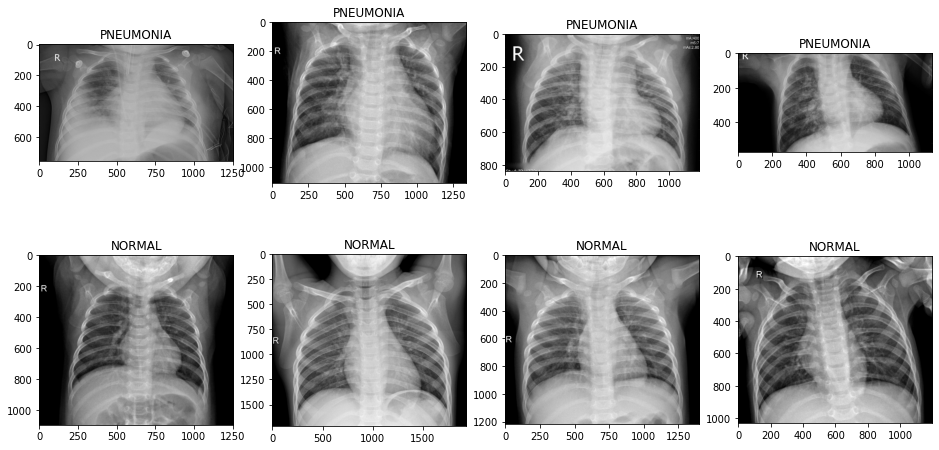

In [5]:
from random import shuffle
from matplotlib import pyplot as plt
import cv2
fig, axs = plt.subplots(2,4, figsize=(16,8))

for i,class_name in enumerate(class_names):
  img_paths = os.listdir(f'{TRAIN_DATA_PATH}/{class_name}')
  shuffle(img_paths)

  for j,image in enumerate(img_paths[:4]):
      img = cv2.imread(os.path.join(f'{TRAIN_DATA_PATH}/{class_name}', image))
      axs[i][j].title.set_text(class_name)
      axs[i][j].imshow(img)

fig.show()

In [ ]:
normal_images_path = f'{TRAIN_DATA_PATH}/NORMAL'
img_file = os.listdir(normal_images_path)[0]
img_path = os.path.join(normal_images_path, img_file)
sample_X = cv2.imread(img_path)
print(sample_X)

In [ ]:
import numpy as np
print('Shape:',sample_X.shape)
print('Std:', np.std(sample_X))
print('Mean:', np.mean(sample_X))
print('Max:', np.max(sample_X))
print('Min:', np.min(sample_X))

In [8]:
from torchvision import datasets, models, transforms

data_transforms = transforms.Compose([
    transforms.Resize((256,256)), 
    transforms.RandomRotation(degrees = (-20,+20)),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),  #automaticcly crops to 0-1
])

In [9]:
train_data = datasets.ImageFolder(TRAIN_DATA_PATH, transform=data_transforms)

In [ ]:
train_data.class_to_idx

In [ ]:
import numpy as np
from PIL import Image
import torch
image_tensor = train_data.__getitem__(10)[0]
print(image_tensor.size())
print(torch.max(image_tensor))
print(torch.min(image_tensor))

to_image_func = transforms.ToPILImage()
to_image_func(image_tensor)

In [14]:
import torch
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

## Models

### MLP

In [17]:
import torch.nn as nn
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.softmax = nn.Softmax(dim=-1)

  
  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.softmax(out) 
    return out

### CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        #TODO
        # Create a convolutional neural network 
        # Input = 3x224x224 image, Output = 2 classes probabilities
        # Use nn.Conv2d layer
        # Use nn.MaxPool2d layer
        # Use nn.Flatten layer
        # Use activation function after Convolutional layer 
        
    def forward(self,input):
        #TODO
        pass


In [61]:
# CNN test
# model = CNN(num_classes=2)
# model(torch.rand(1, 3, 224, 224))

### Pretrained

In [77]:
class MobileNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.model = models.mobilenet_v3_small(pretrained=True)
    last_layer_input_features = self.model.classifier[0].in_features
    # Optional freezing
    for param in model.parameters():
      param.requires_grad = False
      
    self.model.classifier = nn.Linear(last_layer_input_features, num_classes)
    self.softmax = nn.Softmax(dim=-1)
  
  def forward(self,x):
    out = self.model(x)
    out = self.softmax(out)
    return out


## Model instance

In [ ]:
model = MLP(3*224*224, hidden_size=100, num_classes=2)
model(torch.rand(32, 3*224*224)).size()

In [ ]:
# model = CNN(num_classes=2)
# model(torch.rand(32, 3, 224, 224)).size()

In [ ]:
# model = MobileNet(num_classes=2)
# model(torch.rand(32, 3, 224, 224)).size()

In [ ]:
print('number of parameters')
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

## Balancing

In [ ]:
# weights = np.array([image_count['PNEUMONIA'],image_count['NORMAL']])
# weights = weights/sum(image_count.values())
# print(weights)
# print(train_data.class_to_idx)
# criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).float().cuda())
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# #Further improvements - more data

## Training

In [25]:
model = MLP(3*224*224, hidden_size=100, num_classes=2)


In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from torchmetrics import Accuracy

accuracy_function = Accuracy(task='multiclass', num_classes=2) 

model.cuda()
accuracy_function.cuda()

num_epochs = 2

for epoch in range(num_epochs):
  for batch_idx, (inputs, labels) in enumerate(train_loader):
    # inputs = inputs.to('cuda')
    inputs = inputs.reshape(-1,3*224*224).to('cuda') #For MLP
    labels = labels.to('cuda')

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if (batch_idx) % 10 == 0:
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Accuracy: %.4f'
        %(epoch+1, num_epochs, batch_idx, len(train_loader.dataset)//inputs.size()[0], loss.item(), accuracy_function(outputs,labels)))

      

## Evaluation

In [54]:
from torchmetrics import ConfusionMatrix
from sklearn import metrics
from matplotlib import pyplot as plt
from tqdm import tqdm


def get_metrics(model, loader):
  accuracy_function = Accuracy(task='multiclass', num_classes=2) 
  #confusion matrix metric
  cm_function = ConfusionMatrix(task="multiclass", num_classes=2)
  accuracy_function.cuda()
  cm_function.cuda()

  all_predictions = []
  all_labels = []

  model.eval()
  with torch.no_grad():
    for images,labels in tqdm(loader):
      # images = images.cuda()
      images = images.reshape(-1,3*224*224).to('cuda') #FOR MLP
      labels = labels.cuda()
      
      output = model(images)
      all_predictions.append(output) 
      all_labels.append(labels)

  #torch.cat concats tensors along new dimension
  print('\nAccuracy:', accuracy_function(torch.cat(all_predictions), torch.cat(all_labels)).item())
  conf_matrix = cm_function(torch.cat(all_predictions), torch.cat(all_labels))
  cm_display  = metrics.ConfusionMatrixDisplay(
      confusion_matrix = conf_matrix.cpu().numpy(), 
      display_labels = ['NORMAL', 'PNEUMONIA']
  )
  cm_display.plot()
  plt.show()

In [ ]:
get_metrics(model, train_loader) 

## Testing

In [ ]:
TEST_DATA_PATH = './chest_xray/test'
# dont use augmentations for test
test_data_transforms = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(), 
])
test_data = datasets.ImageFolder(TEST_DATA_PATH, transform=test_data_transforms) 
print(test_data.class_to_idx)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

get_metrics(model, test_loader)